In [3]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS, summarize, contrast

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.genmod.generalized_linear_model import GLM

In [5]:
Smarket = load_data('Smarket')
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


In [6]:
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

In [10]:
Smarket.corr()

ValueError: could not convert string to float: 'Up'

<Axes: >

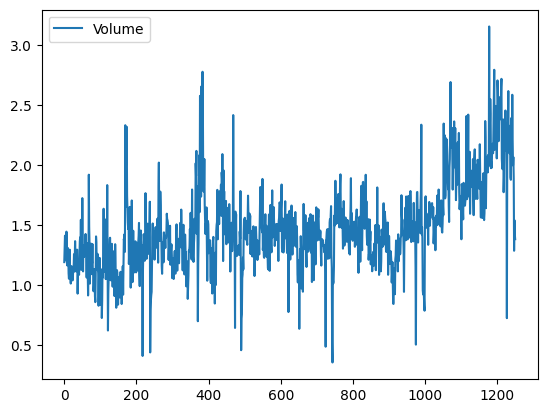

In [11]:
Smarket.plot(y='Volume')

In [12]:
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)

In [13]:
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'

In [15]:
glm = sm.GLM(y, X, family=sm.families.Binomial())

In [16]:
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


## Notes
- p-values imply no clear evidence of real association between lags and Direction

In [17]:
results.params

intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

In [18]:
results.pvalues

intercept    0.600700
Lag1         0.145232
Lag2         0.398352
Lag3         0.824334
Lag4         0.851445
Lag5         0.834998
Volume       0.392404
dtype: float64

In [19]:
probs = results.predict()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [20]:
# Need to predict whether the market will go UP or DOWN. We'll do this for a predicted probability greater than or less than 0.5

In [21]:
labels = np.array(['Down']*1250)
labels[probs>0.5] = 'Up'

In [22]:
confusion_table(labels, Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [23]:
# Each number is implying the number of days, so the True Positives are 507 correctly predicted days

(507+145)/1250, np.mean(labels == Smarket.Direction)

(0.5216, np.float64(0.5216))

In [24]:
# 100 - 52.16 = 47.84 which is the training error rate, not the greatest
# Will create a vector corresponding to the observations from 2001-2004, and then hold out the data from 2005. We will training on these then test and see how accurate it is for future days in 2005

train = (Smarket.Year < 2005) # Vector of 1250 elements
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape

# Elements of train prior to 2005 are TRUE, and after are FALSE - a BOOLEAN array

(252, 9)

In [25]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())

In [26]:
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [27]:
D = Smarket.Direction
L_train, L_test = D.loc[train], D.loc[~train]

In [28]:
labels = np.array(['Down']*252)
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [29]:
np.mean(labels == L_test), np.mean(labels != L_test)
# Accuracy = 48%, Error Rate = 52%

(np.float64(0.4801587301587302), np.float64(0.5198412698412699))

In [32]:
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down']*252)
labels[probs>0.5] = 'Up'
confusion_table(labels, X_test)

ValueError: Mix type of y not allowed, got types {'binary', 'continuous-multioutput'}